In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)


In [4]:
def softmax(x):
    y = np.exp(x)
    return y/np.sum(y)


def ExpBernoulliAlt(alpha,lam,size=None,method='binomial',N=1000): # returns True with probability $e^{alpha-lam}$
    if size is None: 
        size = (1,)
    if type(size) is int:
        size = (size,)
    elif type(size) is not tuple:
        raise TypeError("size must be int or tuple")
    
    if method == 'poisson':
        M=np.random.poisson(lam=lam,size=size) # Get integers from poisson(lam).
    elif method == 'binomial': # N is number to flip
        M=np.random.binomial(N,lam/N,size=size)

    spikes = np.random.random(size)<np.power(alpha/lam,M) # Spike if all K trials are successful
    return spikes

def approx_fn(q,K,T,comb_method='OR'):
    n_embed,n_keys = K.shape

    # Create spike arrays based on the values in q and K
    q_spikes = np.random.random((T,n_embed,1))<q
    K_spikes = np.random.random((T,n_embed,n_keys))<K
    scaling_spikes = np.random.random((T,n_embed,n_keys)) < 1/np.sqrt(n_embed) # K x N matrix of boolean mask
    attn_score_spikes = q_spikes & K_spikes & scaling_spikes # AND

    # Summing works better, but OR can work well if input rates are low
    if comb_method == 'OR':
        attn_score_spikes = np.any(attn_score_spikes, axis=1) # OR
    elif comb_method == 'SUM':
        attn_score_spikes = np.sum(attn_score_spikes, axis=1) # SUM
    else:
        assert(0)
    # approx_attn_scores = np.mean(attn_score_spikes,axis=0) # Get spike rates
    return attn_score_spikes

## Computing the scaled dot product between two vectors

Query: $q$\
Key: $k$\
Scaled dot product: $q\cdot k/\sqrt{N}$


Basic method: 

* Create spikes trains with rates proportional to the elements of $k$, $q$ and $1/\sqrt{N}$ (where $N$ is the lenght of $q,k$).
* Use AND gates to combine this, yields spike trains with rates proportional to $q_ik_i/\sqrt{N}$.
* Sum these spike trains together. If each individual spike train is sufficiently sparse, we can approximate this with an inclusive OR.

Challenges: 
* What if we want to using key or query vectors that are not in $[0,1]^N$?
* What if input spike trains are not very sparse? 

In [3]:
N=5 # Embedding dimension
T=100000 # Number of trials / steps
max_rate = 0.2 # Maximum allowed spike probability

# Generate two random vectors in [0,1]^N
q,k = max_rate*np.random.random((2,N,1)) # spike probabilties for key and query

# Approximate scaled dot product using spikes
approx = np.mean(approx_fn(q,k,T,comb_method='OR'),axis=0).item()

# Exact scaled dot product
exact = (q.T@k/np.sqrt(N)).item()

# Error
percent_error = np.abs((approx - exact) / exact) * 100
angle = np.arccos(q.T@k/np.sqrt(q.T@q*k.T@k)).item()

print("Exact scaled dot product: ", round(exact, 5))
print("Approximation using spikes: ", round(approx, 5))
print("Percent error: ", round(percent_error, 5), "%")
print("Angle: ", round(angle, 5), " radians")


Exact scaled dot product:  0.01505
Approximation using spikes:  0.01439
Percent error:  4.37945 %
Angle:  0.54254  radians


## What is the effect of sparsity?

* The OR method works better for sparse spike trains, because the probability of collisions is low.
* The SUM method works better for dense spike trains, because the variance of the sample spike rate is lower.
* Let's compare these!

* As can be seen above, higher spike probabilities lead to less accurate approximations when combining channels using the inclusive OR method. 
* How does the maximum spike probability of the inputs affect this?

/tmp/ipykernel_12900/1380819567.py:18: RuntimeWarning: invalid value encountered in scalar divide
  error = np.sqrt(np.mean(diff**2)/np.mean(attn_scores**2))*100
/tmp/ipykernel_12900/1380819567.py:24: RuntimeWarning: invalid value encountered in scalar divide
  error = np.sqrt(np.mean(diff**2)/np.mean(attn_scores**2))*100


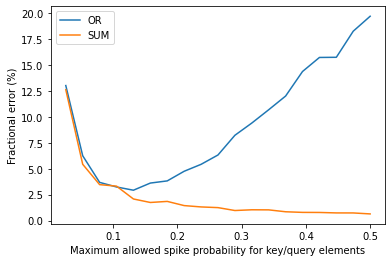

In [4]:
n_embed=64 # Embedding dimension
n_keys=100 # Number keys
T=50000 #50000 # Number of time steps

OR_errors, SUM_errors = [], []
max_rates = np.linspace(0.0,0.5,20)

for max_rate in max_rates:

    # Get keys/query and compute exact scaled dot products
    q =  max_rate*np.random.random((n_embed,1)) # Query
    K = max_rate*np.random.random((n_embed,n_keys)) # Keys
    attn_scores = q.T@K/np.sqrt(n_embed) # Exact attention scores

    # OR (avg error) 
    approx_attn_scores = np.mean(approx_fn(q,K,T,comb_method='OR'),axis=0)
    diff = attn_scores - approx_attn_scores
    error = np.sqrt(np.mean(diff**2)/np.mean(attn_scores**2))*100
    OR_errors.append(error)

    # SUM (avg error) 
    approx_attn_scores = np.mean(approx_fn(q,K,T,comb_method='SUM'),axis=0)
    diff = attn_scores - approx_attn_scores
    error = np.sqrt(np.mean(diff**2)/np.mean(attn_scores**2))*100
    SUM_errors.append(error)

plt.plot(max_rates,OR_errors,label='OR')
plt.plot(max_rates,SUM_errors,label='SUM')
plt.xlabel('Maximum allowed spike probability for key/query elements')
plt.ylabel('Fractional error (%)')
plt.legend()
plt.show()


## Softmax

Given a vector $\bar{\alpha}=(\alpha_1,\alpha_2,\ldots,\alpha_n)$, we define: $softmax(\bar{\alpha})=(e^{\alpha_i-\lambda})_{i\in n}$, where $\lambda=LSE(\bar{\alpha})=log(\sum e^{\alpha_i})$

* Rather than trying to compute $\lambda$ explicitly, we note that $\lambda$ is the unique value that makes the softmax entries sum to 1. 
* We can adjust $\lambda$ dynamically to make this true. 
* Therefore, the problem of compute softmax reduces to the problem of computing exponentials (using spikes).



### Idea

* Use the approximation: $e^{\alpha-\lambda}\approx (1-\frac{\lambda-\alpha}{N})^N$ for large $N$.
* This reduces the problem. We just need to be able to generate spikes with probability $1-(\lambda-\alpha)/N$.
* It may be useful to rewrite this expression as a more complex probability: $1-(\lambda-\alpha)/N=1-(\lambda/N)(1-\alpha/\lambda)$
* This expression is the probability that $A\to B$, where $A$ and $B$ are independent Bernoulli r.v.s with probabilities $\lambda/N$ and $\alpha/\lambda$, respectively.
* Details: Let A and B be (independent) Bernoulli r.v.s Then $P(A\to B) = P(\lnot(A\wedge\lnot B))=1-P(A)[1-P(B)]$
* Method: Flip $N$ coins each with probability $\lambda/N$. For each coin that comes up heads, flip a coin with probability $\alpha/\lambda$. If all of the coins on this second round come up heads, we transmit a spike. The probability of spiking will be roughly $e^{\alpha-\lambda}$ if $N$ is sufficiently large. 


<!-- ![Exponential spiking](image1.svg) -->

<img src="image1.svg" alt="Description" width="50%"/>

Note: The number of successes on the first round is distributed roughly like Poisson($\lambda$) when $N$ is large. What if we actually use Poisson($\lambda$)?

Suppose that $k\sim Poisson(\lambda)$. What is the probability that $k$ independent Bernoulli($\frac{\alpha}{\lambda}$) trials are all successful?

Spike probability: $\sum_k p(k)(\frac{\alpha}{\lambda})^k=\sum_k e^{-\lambda}\frac{\lambda^k}{k!}(\frac{\alpha}{\lambda})^k=e^{-\lambda}\sum_k\frac{\alpha^k}{k!}=e^{\alpha-\lambda}$.

<!-- What if we replace the Poisson with a Binomial approximation (using N trials and success probability $\lambda/N$)?

Answer: $\sum_k {N\choose k}(\frac{\lambda}{N})^k(1-\frac{\lambda}{N})^{N-k}(\frac{\alpha}{\lambda})^k=(1-\frac{\lambda}{N})^N\sum_k{N \choose k}(\frac{\alpha}{N-\lambda})^k$ -->


In [5]:
# Basic exponential

T=100000
alpha = 5*np.random.random()
lam = alpha + 1

# Exact exponential
exact = np.exp(alpha-lam)
print("Exact exponential: ",exact)

# Approximate exponential using spikes
spikes = ExpBernoulliAlt(alpha,lam,T)
approx = np.mean(spikes)
print("Approximation using spikes: ",approx)

# Error
error = np.abs((exact-approx)/exact)
print("Error: ",100*error,'%')


Exact exponential:  0.3678794411714424
Approximation using spikes:  0.36521
Error:  0.725629342847233 %


In [6]:
# Basic softmax
n_embed = 8
dt = 0.5
N=10
T=100000

alpha = np.random.random(n_embed) # alpha
exact = softmax(np.array(alpha))
lam = max(alpha) # Initial value for lambda

# Loops
for _ in range(N): # Iterate to adjust lambda
    spikes = [ExpBernoulliAlt(x,lam,T) for x in alpha] # Get spike trains for each channel
    approx = [np.mean(z) for z in spikes]
    total_probability = np.sum(approx)
    print('Total probability (this should be 1): ', total_probability)
    lam += dt*(total_probability-1) # How the fuck did copilot guess this line from "lam += dt*"?????!!!!!!!!!!
error = np.sqrt(np.mean((exact-approx)**2)/np.mean(exact**2))*100

print('\n')
print('Original vector: ',alpha)
print('Exact softmax: ',exact)
print('Approximation using spike: ',approx)
print('Error: ',error,'%')

Total probability (this should be 1):  5.6697299999999995
Total probability (this should be 1):  0.54815
Total probability (this should be 1):  0.6869000000000001
Total probability (this should be 1):  0.80474
Total probability (this should be 1):  0.88513
Total probability (this should be 1):  0.93638
Total probability (this should be 1):  0.96611
Total probability (this should be 1):  0.98882
Total probability (this should be 1):  0.9968899999999999
Total probability (this should be 1):  0.9964900000000001


Original vector:  [0.913 0.961 0.532 0.65  0.102 0.269 0.789 0.406]
Exact softmax:  [0.168 0.176 0.115 0.129 0.075 0.088 0.148 0.101]
Approximation using spike:  [0.167, 0.17514, 0.11452, 0.1285, 0.07442, 0.08873, 0.14753, 0.10065]
Error:  0.5037065999649422 %


In [28]:
np.set_printoptions(precision=3)
n_embed=4 # Embedding dimension
n_keys=5 # Number keys
M=1000
T=20000
max_rate = 0.5
lam=1.0

# Get keys/query and compute exact scaled dot products
q =  max_rate*np.random.random((n_embed,1)) # Query
K = max_rate*np.random.random((n_embed,n_keys)) # Keys
attn_scores = q.T@K/np.sqrt(n_embed) # Exact attention scores
print("Attention scores: ",attn_scores)

exact = np.exp(attn_scores-lam)
print("Exact exponentials: ",exact)

A_spikes = np.random.random((M,T,n_keys)) < lam/T
B_spikes=approx_fn(q/lam,K,M*T,comb_method='OR').reshape(M,T,-1)
attn_score_spikes = ~A_spikes | B_spikes # AND

approx = np.mean(np.all(attn_score_spikes,axis=1),axis=0)
error = np.sqrt(np.mean((approx-exact)**2)/np.mean(exact**2))
print("Approximation using spikes: ",approx)
print("Error: ",100*error,'%')


Attention scores:  [[0.078 0.108 0.092 0.12  0.122]]
Exact exponentials:  [[0.398 0.41  0.403 0.415 0.415]]
Approximation using spikes:  [0.39  0.425 0.428 0.409 0.415]
Error:  3.3229223179537892 %


## We can avoid doing the sum in the dot products...

* Basic idea: $exp(q\cdot k-\lambda) = exp(\sum_N q_is_i-\lambda)=\prod_N exp(r_is_i-\lambda/N)$
* This avoids summing spike trains, so it's okay if $r_is_i$ is close to 1 (i.e. we don't need sparsity).
* We can do $N\times K$ initial coin flips, each with probability $\lambda/N$. 
* Whenever coin $(n,k)$ lands heads up, we perform a second coin flip with probability $r_ns_n/\lambda\sqrt{N}$.
* If all of the second round coin flips come up heads, we transmit a spike.
* Spike probability: $\prod_n\prod_k 1-\frac{\lambda}{K}(1-r_ns_n/\lambda\sqrt{N}) = \prod_n [1-\frac{\lambda}{K}(1-r_ns_n/\lambda\sqrt{N})]^K\prod_n [1-\frac{\lambda-r_ns_n/\sqrt{N}}{K})]^K\approx \prod_n e^{r_ns_n/\sqrt{N}-\lambda}=e^{r\cdot s/\sqrt{N}-N\lambda}$

##### Below is a full exmaple, including adjusting $\lambda$.

In [56]:
np.set_printoptions(precision=3)
n_embed=4 # Embedding dimension
n_keys=5 # Number keys
N=1000 # How many coins to flip in first phase
T=200 
dt=0.1
lam=1
max_rate = 1.0

# Get keys/query and compute exact scaled dot products
q =  max_rate*np.random.random((n_embed,1)) # Query
K = max_rate*np.random.random((n_embed,n_keys)) # Keys

# Get correct lambda value
##################################################################################

for i in range(50):
    # Create spike arrays based on the values in q and K
    q_spikes = np.random.random((N,T,n_embed,1))<q
    K_spikes = np.random.random((N,T,n_embed,n_keys))<K
    scaling_spikes = np.random.random((N,T,n_embed,n_keys)) < 1/(lam*np.sqrt(n_embed)) # K x N matrix of boolean mask
    # scaling_spikes = np.random.random((1,T,n_embed,n_keys)) < 1/lam*np.sqrt(n_embed) # K x N matrix of boolean mask
    A_spikes = np.random.random((N,T,n_embed,n_keys)) < lam/T
    B_spikes = q_spikes & K_spikes & scaling_spikes
    approx_spikes = ~A_spikes | B_spikes # A->B 

    approx = np.mean(np.all(approx_spikes,axis=(1,2)),axis=0)
    if i%5==0:
        print("Total probability: ",np.sum(approx))
        print("Lambda: ",lam)
    lam -= dt*(1-np.sum(approx)) # Adjust lambda

###################################################################################

# Softmax
####################################################################################
N=10000
T=1000

attn_scores = q.T@K/np.sqrt(n_embed) # Exact attention scores
print("\nAttention scores: ",attn_scores)
exact = softmax(attn_scores)
print("Exact softmax: ",exact)

# Create spike arrays based on the values in q and K
q_spikes = np.random.random((N,T,n_embed,1))<q
K_spikes = np.random.random((N,T,n_embed,n_keys))<K
# scaling_spikes = np.random.random((N,T,n_embed,n_keys)) < 1/(lam*np.sqrt(n_embed)) # K x N matrix of boolean mask
scaling_spikes = np.random.random((N,T,n_embed,n_keys)) < 1/(lam*np.sqrt(n_embed)) # K x N matrix of boolean mask
A_spikes = np.random.random((N,T,n_embed,n_keys)) < lam/T
B_spikes = q_spikes & K_spikes & scaling_spikes
approx_spikes = ~A_spikes | B_spikes # A -> B

approx = np.mean(np.all(approx_spikes,axis=(1,2)),axis=0)
error = np.sqrt(np.mean((approx-exact)**2)/np.mean(exact**2))
print("Approximation using spikes: ",approx)
print("Error: ",100*error,'%')
print("Total probability: ",np.sum(approx))


Total probability:  0.131
Lambda:  1
Total probability:  0.572
Lambda:  0.6367000000000002
Total probability:  0.9
Lambda:  0.5198000000000002
Total probability:  0.994
Lambda:  0.4934000000000001
Total probability:  1.027
Lambda:  0.49170000000000014
Total probability:  1.045
Lambda:  0.49110000000000004
Total probability:  0.923
Lambda:  0.5037
Total probability:  0.988
Lambda:  0.49230000000000007
Total probability:  1.04
Lambda:  0.4903000000000001
Total probability:  1.0150000000000001
Lambda:  0.4934000000000001

Attention scores:  [[0.414 0.294 0.567 0.362 0.166]]
Exact softmax:  [[0.209 0.185 0.244 0.199 0.163]]
Approximation using spikes:  [0.203 0.19  0.244 0.195 0.163]
Error:  1.8828207345448267 %
Total probability:  0.9951
